# Import package dan import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

d:\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("../data/loan_data_2007_2014.csv", index_col=0)
df = data.copy()
df.head()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_22344\454855539.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/loan_data_2007_2014.csv", index_col=0)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# membersihkan data dari missing value

<AxesSubplot:>

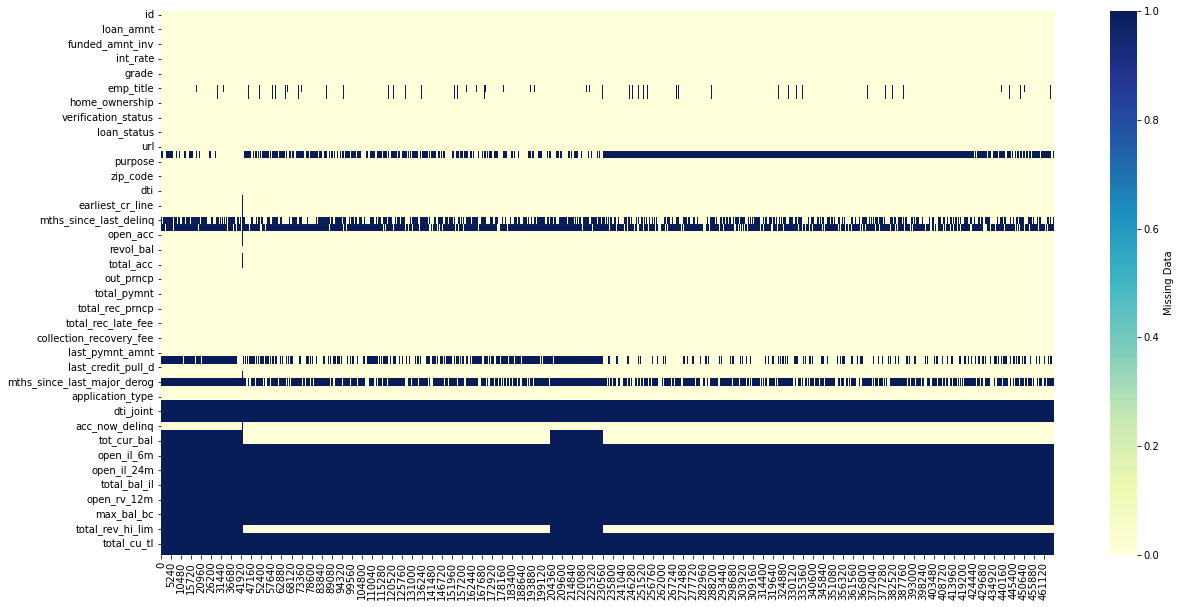

In [3]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna().T,
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [4]:
df.isna().sum().unique()

array([     0,  27588,  21008,      4, 340302,     20,     29, 250351,
       403647,    340,    376, 227214,     42,    145, 367311, 466285,
        70276], dtype=int64)

In [5]:
df.isna().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 74, dtype: int64

In [6]:
df.shape

(466285, 74)

In [7]:
df = df[df.columns[(df.isna().sum() <= 200000)]]
df.shape, df.isna().sum().unique()

((466285, 52),
 array([    0, 27588, 21008,     4,    20,    29,   340,   376,    42,
          145, 70276], dtype=int64))

## mengatasi missing value intuk kolom emp title

saya akan untuk meng impute kolom tersebut dengan nilai emp title yang lain dengan rata2 loan amt yang mirip dengan rata2 loan amt pada kolom yang terdapat missing value

In [8]:
df.columns[(df.isna().sum() == 27588)]

Index(['emp_title'], dtype='object')

In [9]:
# mencari rata2 dan maksimum dari kolom emp_title yang memiliki missing value
df[df['emp_title'].isna()].describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.758800e+04,2.758800e+04,27588.000000,27588.000000,27588.000000,27588.000000,27588.000000,2.758400e+04,27588.000000,27576.000000,...,27588.000000,27588.000000,27588.000000,27588.000000,27564.000000,27588.0,27576.000000,23250.000000,2.325000e+04,2.325000e+04
mean,1.226417e+07,1.374623e+07,12450.038966,12423.555531,12370.576206,13.882511,389.109667,5.993913e+04,17.355970,0.244996,...,0.686942,84.508664,8.952722,2167.769587,0.009287,1.0,0.003626,234.189978,1.052996e+05,2.873323e+04
std,1.054599e+07,1.130764e+07,8149.973629,8125.978976,8133.407097,4.337363,248.782936,4.950587e+04,8.391918,0.731293,...,5.546348,525.725315,95.506122,4467.842366,0.107009,0.0,0.063628,2027.407953,1.382322e+05,3.371894e+04
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.690000,2.000000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,3.630122e+06,4.319177e+06,6000.000000,6000.000000,6000.000000,10.990000,202.977500,3.200000e+04,10.910000,0.000000,...,0.000000,0.000000,0.000000,245.267500,0.000000,1.0,0.000000,0.000000,1.577825e+04,1.190000e+04
50%,9.270024e+06,1.102986e+07,10000.000000,10000.000000,10000.000000,13.670000,330.700000,4.945150e+04,17.020000,0.000000,...,0.000000,0.000000,0.000000,431.260000,0.000000,1.0,0.000000,0.000000,4.259400e+04,2.020000e+04
75%,1.855476e+07,2.064871e+07,17000.000000,17000.000000,17000.000000,16.692500,513.330000,7.152000e+04,23.460000,0.000000,...,0.000000,0.000000,0.000000,1059.977500,0.000000,1.0,0.000000,0.000000,1.580712e+05,3.470000e+04
max,3.784184e+07,4.060491e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,1.440000e+06,39.990000,13.000000,...,189.180000,23035.920000,6972.590000,35680.840000,6.000000,1.0,2.000000,126297.000000,3.437283e+06,1.998700e+06


In [10]:
# saya menemukan bahwa nilai rata2 loat_amnt dari kolom yang memiliki missing value ada diangka 12450.038966 maka dari itu saya mencoba mencari pekerjaan lain yang memiliki nilai rata2 loan_amnt yang lebih besar dari 12000 dan lebih kecil dari 13000

lower_bound = 12000
upper_bound = 13000

job = df.groupby('emp_title').filter(lambda x: ((x.loan_amnt >= lower_bound) & (x.loan_amnt <= upper_bound)).all())

berikut adalah list pekerjaan lain yang memiliki rata2 loan_amnt lebih besar dari 12000 dan lebih kecil dari 13000

In [11]:
job['emp_title'].value_counts()

Cleary Gottlieb                          3
Departmental Technician                  3
Waffle House                             3
DRVER                                    2
derrick man                              2
                                        ..
FAA/Ontario Air Traffic Control Tower    1
T White Trkg inc.                        1
industrial threaded products             1
Holsum Bakery of Tolleson, LLC           1
Director of High Performance             1
Name: emp_title, Length: 14057, dtype: int64

karena hasil tersebut tidak menunjukkan adanya data yang berkumpul, maka dari itu saya memutuskan untuk meng impute kolom tersebut dengan Unknown

In [12]:
df['emp_title'].fillna('Other', inplace=True)

In [13]:
df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                         0
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                    

## mengatasi missing value intuk kolom emp length

sama seperti sebelumnya, saya berniat untuk mengimpute nilai yang kosong dengan nilai lain yang memiliki rata amt amount yang mirip

In [14]:
#menihat bagaimana persebaran data pada kolom ini
df.emp_length.value_counts()

10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64

In [15]:
#mencari rata2 amt amount dari kolom yang memiliki missing value
df[df['emp_length'].isna()].describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.100800e+04,2.100800e+04,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,...,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.0,21008.000000,18947.000000,1.894700e+04,18947.000000
mean,1.453701e+07,1.621312e+07,11542.995526,11533.108816,11520.005556,13.966062,359.853819,49428.978403,18.451529,0.245621,...,0.483539,64.982890,7.405490,1981.774990,0.010901,1.0,0.003713,249.546577,9.261982e+04,26804.934079
std,1.090263e+07,1.161648e+07,7506.910922,7497.977584,7491.605228,4.295129,223.879042,30929.049883,8.348041,0.741836,...,4.430532,452.302013,69.043543,4137.360676,0.117191,0.0,0.064617,2038.887405,1.154398e+05,26749.654219
min,4.415470e+05,4.988400e+05,1000.000000,1000.000000,400.000000,5.420000,23.010000,3000.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000
25%,5.790457e+06,7.190107e+06,6000.000000,6000.000000,5950.000000,10.990000,194.662500,30000.000000,12.170000,0.000000,...,0.000000,0.000000,0.000000,231.400000,0.000000,1.0,0.000000,0.000000,1.423350e+04,11500.000000
50%,1.172809e+07,1.367827e+07,10000.000000,10000.000000,10000.000000,13.980000,315.265000,44500.000000,18.310000,0.000000,...,0.000000,0.000000,0.000000,388.060000,0.000000,1.0,0.000000,0.000000,3.796700e+04,19200.000000
75%,2.280513e+07,2.497789e+07,15075.000000,15000.000000,15000.000000,16.780000,477.115000,61503.250000,24.600000,0.000000,...,0.000000,0.000000,0.000000,881.225000,0.000000,1.0,0.000000,0.000000,1.420410e+05,32900.000000
max,3.784184e+07,4.060491e+07,35000.000000,35000.000000,35000.000000,26.060000,1368.750000,900000.000000,39.990000,13.000000,...,184.600000,23035.920000,4146.465600,35680.840000,6.000000,1.0,2.000000,126297.000000,1.500259e+06,649300.000000


In [16]:
# membuat lower bound dan upper bound untuk kolom emp_length
lower_bound = 11500
upper_bound = 11600


# melakukan filtering data berdasarkan lower bound dan upper bound
length = df.groupby('emp_title').filter(lambda x: ((x.loan_amnt.mean() >= lower_bound) & (x.loan_amnt.mean() <= upper_bound)).all())

In [17]:
# mendapatkan hasil bahwa berdasarkan hasil filtering sebelumnya didapat bahwa adanya data yang berkumpul yaitu ada di 10=years sehingga saya akan mengimpute 10=years ke kolom emp_length

length.emp_length.value_counts()

10+ years    745
2 years      258
< 1 year     232
5 years      207
3 years      196
4 years      182
6 years      177
1 year       168
7 years      151
8 years      133
9 years      112
Name: emp_length, dtype: int64

In [18]:
# mengimpute data ke kolom emp_length

df['emp_length'].fillna('10+ years', inplace=True)

In [19]:
# mengecek apakah ada data yang memiliki missing value

df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                         0
emp_length                        0
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                    

## mengatasi missing value pada kolom tot_coll_amt, tot_cur_bal, dan total_rev_hi_lim

saya berniat untuk mengimpute kolomg tersebut dengan nilai data2 dari setiap kolom

In [20]:
# mencari rata2 dari setiap kolom

df['tot_coll_amt'].describe(), df['tot_cur_bal'].describe(), df['total_rev_hi_lim'].describe()

(count    3.960090e+05
 mean     1.919135e+02
 std      1.463021e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      9.152545e+06
 Name: tot_coll_amt, dtype: float64,
 count    3.960090e+05
 mean     1.388017e+05
 std      1.521147e+05
 min      0.000000e+00
 25%      2.861800e+04
 50%      8.153900e+04
 75%      2.089530e+05
 max      8.000078e+06
 Name: tot_cur_bal, dtype: float64,
 count    3.960090e+05
 mean     3.037909e+04
 std      3.724713e+04
 min      0.000000e+00
 25%      1.350000e+04
 50%      2.280000e+04
 75%      3.790000e+04
 max      9.999999e+06
 Name: total_rev_hi_lim, dtype: float64)

In [21]:
# mengimpute kolom tersebut dengan nilai rata2

df['tot_coll_amt'].fillna(df['tot_coll_amt'].mean(), inplace=True)
df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean(), inplace=True)
df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].mean(), inplace=True)

In [22]:
# melihat hasil impute apakah nilai rata2 dari setiap kolom berubah banyak atau tidak

df['tot_coll_amt'].describe(), df['tot_cur_bal'].describe(), df['total_rev_hi_lim'].describe()

(count    4.662850e+05
 mean     1.919135e+02
 std      1.348272e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      6.200000e+01
 max      9.152545e+06
 Name: tot_coll_amt, dtype: float64,
 count    4.662850e+05
 mean     1.388017e+05
 std      1.401838e+05
 min      0.000000e+00
 25%      3.361100e+04
 50%      1.271600e+05
 75%      1.849300e+05
 max      8.000078e+06
 Name: tot_cur_bal, dtype: float64,
 count    4.662850e+05
 mean     3.037909e+04
 std      3.432571e+04
 min      0.000000e+00
 25%      1.500000e+04
 50%      2.710000e+04
 75%      3.430000e+04
 max      9.999999e+06
 Name: total_rev_hi_lim, dtype: float64)

In [23]:
df.isna().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_title                       0
emp_length                      0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                          20
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal     

In [24]:
df.isna().sum().unique()

array([  0,   4,  20,  29, 340, 376,  42, 145], dtype=int64)

## sisa kolom yang memiliki missing value tidak akan saya impute melainkan akan saya drop

In [25]:
df.dropna(inplace=True)

In [26]:
df.isna().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_ac

<AxesSubplot:>

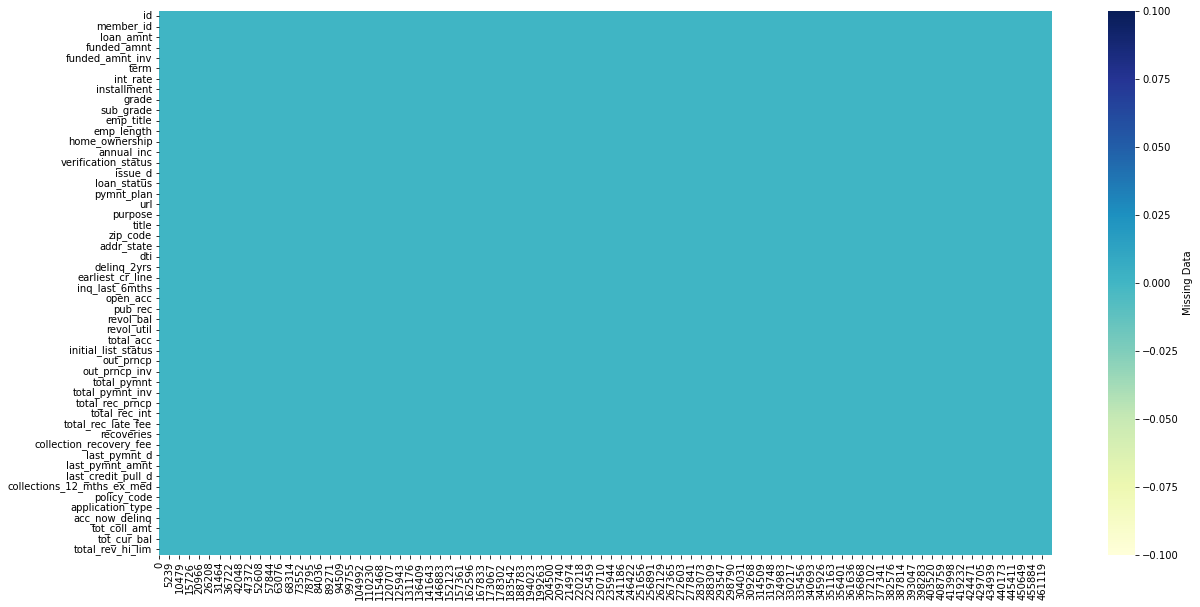

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna().T,
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# mempersempit value dari kolom target

In [28]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [29]:
df['loan_status'].value_counts()

Current                                                224096
Fully Paid                                             184524
Charged Off                                             42056
Late (31-120 days)                                       6895
In Grace Period                                          3144
Does not meet the credit policy. Status:Fully Paid       1913
Late (16-30 days)                                        1217
Default                                                   832
Does not meet the credit policy. Status:Charged Off       725
Name: loan_status, dtype: int64

In [30]:
# mengubah kolom loan_status menjadi binary

mapping_loan_status = {
    'Current': 'Good',
    'Fully Paid': 'Good',
    'Charged Off': 'Bad',
    'Late (31-120 days)': 'Bad',
    'In Grace Period': 'Good',
    'Does not meet the credit policy. Status:Fully Paid': 'Good',
    'Late (16-30 days)': 'Bad',
    'Default': 'Good',
    'Does not meet the credit policy. Status:Charged Off': 'Bad'
}

df['loan_status'] = df['loan_status'].map(mapping_loan_status)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,Jan-15,171.62,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,Jun-14,649.91,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,Jan-15,357.48,Jan-15,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,Jan-16,67.79,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771


In [31]:
df['loan_status'].value_counts()

Good    414509
Bad      50893
Name: loan_status, dtype: int64

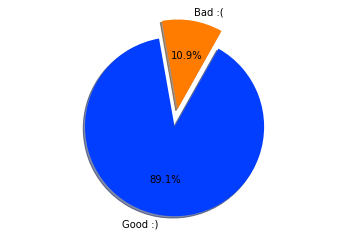

In [32]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [ 'Good :)', 'Bad :(']
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:6]

fig1, ax1 = plt.subplots()
ax1.pie(df['loan_status'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')
plt.show()

### menghapus kolom-kolom yang sejauh ini tidak akan digunakan menurut saya

In [33]:
df.drop(columns=['id', 'member_id'], inplace=True)

## Membagi kolom menjadi kolom numerik dan kategorik untuk memudahkan pemrosesan

In [34]:
cat = df[df.dtypes[df.dtypes == 'object'].index]
num = df[df.dtypes[df.dtypes != 'object'].index]

In [35]:
cat.columns, num.columns

(Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
        'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
        'last_credit_pull_d', 'application_type'],
       dtype='object'),
 Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
        'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
        'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
        'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
        'collection_recovery_fee', 'last_pymnt_amnt',
        'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
        'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
       dtype='object'))

## memproses kolom categoric

In [36]:
cat.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,Other,10+ years,RENT,Verified,Dec-11,Good,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Bad,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,Apr-99,f,Apr-13,Sep-13,INDIVIDUAL
2,36 months,C,C5,Other,10+ years,RENT,Not Verified,Dec-11,Good,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,Jan-16,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Good,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,Feb-96,f,Jan-15,Jan-15,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Good,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,Jan-96,f,Jan-16,Jan-16,INDIVIDUAL


setelah melihat isi dari data yang bersifat kategorik, saya menemukan bahwa ada beberapa kolom yang perlu dihapus yaitu kolom zip_code, issue_d, url, addr_state, earliest_cr_line, last_pymnt_d, last_credit_pull_d

In [37]:
df.drop(columns=['zip_code', 'issue_d', 'url', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], inplace=True)

In [38]:
cat['application_type'].value_counts()

INDIVIDUAL    465402
Name: application_type, dtype: int64

kerena kolom application type hanya memiliki satu nilai maka dari itu kolom tersebut juga harus di hapus

In [39]:
df.drop(columns=['application_type'], inplace=True)

update nilai pada variabel kategorik

In [40]:
cat = df[df.dtypes[df.dtypes == 'object'].index]

In [41]:
cat.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,initial_list_status
0,36 months,B,B2,Other,10+ years,RENT,Verified,Good,n,credit_card,Computer,f
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Bad,n,car,bike,f
2,36 months,C,C5,Other,10+ years,RENT,Not Verified,Good,n,small_business,real estate business,f
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Good,n,other,personel,f
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Good,n,other,Personal,f


In [42]:
#melihat statistis dari kolom kategorik
cat.describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,initial_list_status
count,465402,465402,465402,465402,465402,465402,465402,465402,465402,465402,465402,465402
unique,2,7,35,205073,11,6,3,2,2,14,62879,2
top,36 months,B,B3,Other,10+ years,MORTGAGE,Verified,Good,n,debt_consolidation,Debt consolidation,f
freq,337250,136769,31654,27508,170814,235539,167792,414509,465393,273815,163888,302325


In [43]:
# melihat kolom apa saja yang ada di categorical. untuk nantinya akan saya proses satu persatu
cat.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'initial_list_status'],
      dtype='object')

In [44]:
# membuat dataframe baru untuk membagi data berdasarkan loan status
good_loan = df[df['loan_status'] == 'Good'].copy()
bad_loan = df[df['loan_status'] == 'Bad'].copy()

#### melihat persebaran kolom <b>Term<b>

In [45]:
print(df['term'].value_counts(), "\n36 months percentage", df['term'].value_counts()[0]/df['term'].value_counts().sum(), "\n60 months percentage", df['term'].value_counts()[1]/df['term'].value_counts().sum())

 36 months    337250
 60 months    128152
Name: term, dtype: int64 
36 months percentage 0.7246423522030416 
60 months percentage 0.2753576477969583


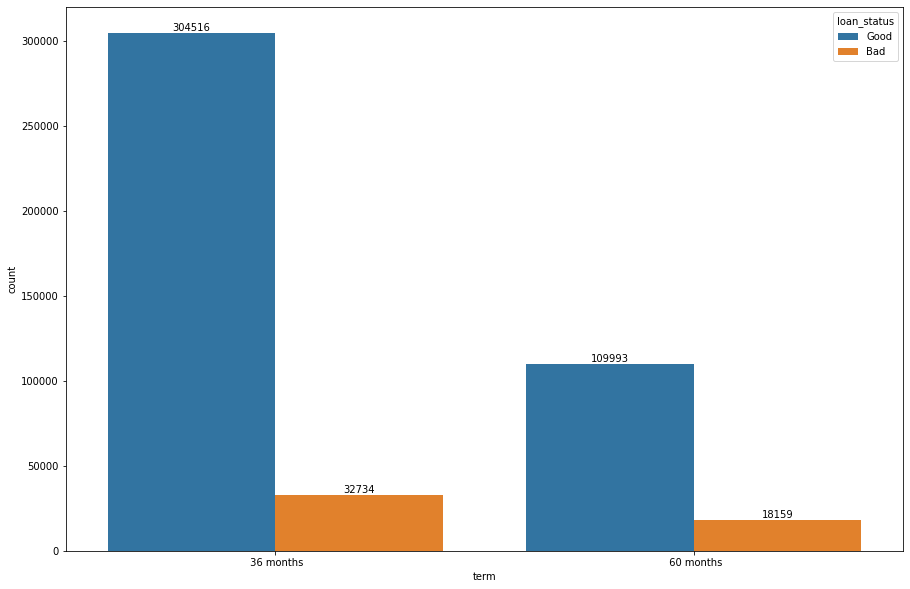

In [46]:
# melihat persebaran kolom term berdasarkan loan statusnya menggunakan diagram

plt.figure(figsize=(15,10))
ax = sns.countplot(x='term', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

dari diagram diatas, dapat dilihat bahwa term 36 bulan memiliki data good loan yang lebih dibandingkan dengan term 60 bulan yaitu sebanyak 304516 user dengan good loan dengan term 36 bulan dan 109993 untuk 60 bulan dengan good loan.

disisi lain, bad loan untuk 36 bulan juga lebih tinggi dibandingkan dengan bad loan 60 bulan yaitu ada diangka 32734 untuk bad loan 36 bulan dan 18159 untuk 60 bulan.

In [47]:
print("bad loan ratio for 36 months",df[df['term'] == ' 36 months'].groupby('loan_status').size()[0]
        / df[df['term'] == ' 36 months'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for 60 months",df[df['term'] == ' 60 months'].groupby('loan_status').size()[0]
        / df[df['term'] == ' 60 months'].groupby('loan_status').size().sum())

bad loan ratio for 36 months 0.09706152705707932 
bad loan ratio for 60 months 0.14169892003246146


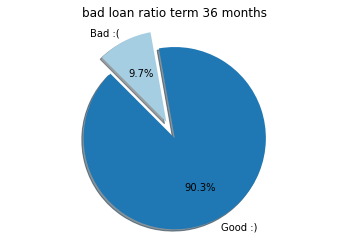

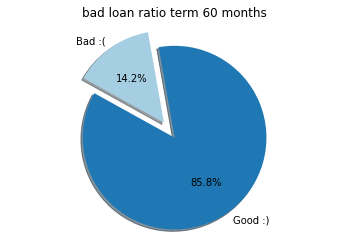

In [48]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# pie chart untuk 36 months term
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio term 36 months')
ax1.pie(df[df['term'] == ' 36 months'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# pie chart untuk 60 months term
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio term 60 months')
ax1.pie(df[df['term'] == ' 60 months'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

kesimpulan sementara yang dapat diambil adalah orang-orang dengan waktu peminjaman selama 36 bulan cenderung memiliki status good loan. hal ini bisa dilihat dari <b> bad loan ratio 60 months ada diangka 14.2% <b> dan <b>bad loan ratio 36 months ada diangka 9.7%<b>

#### Melihat persebaran kolom <b>Grade<b>

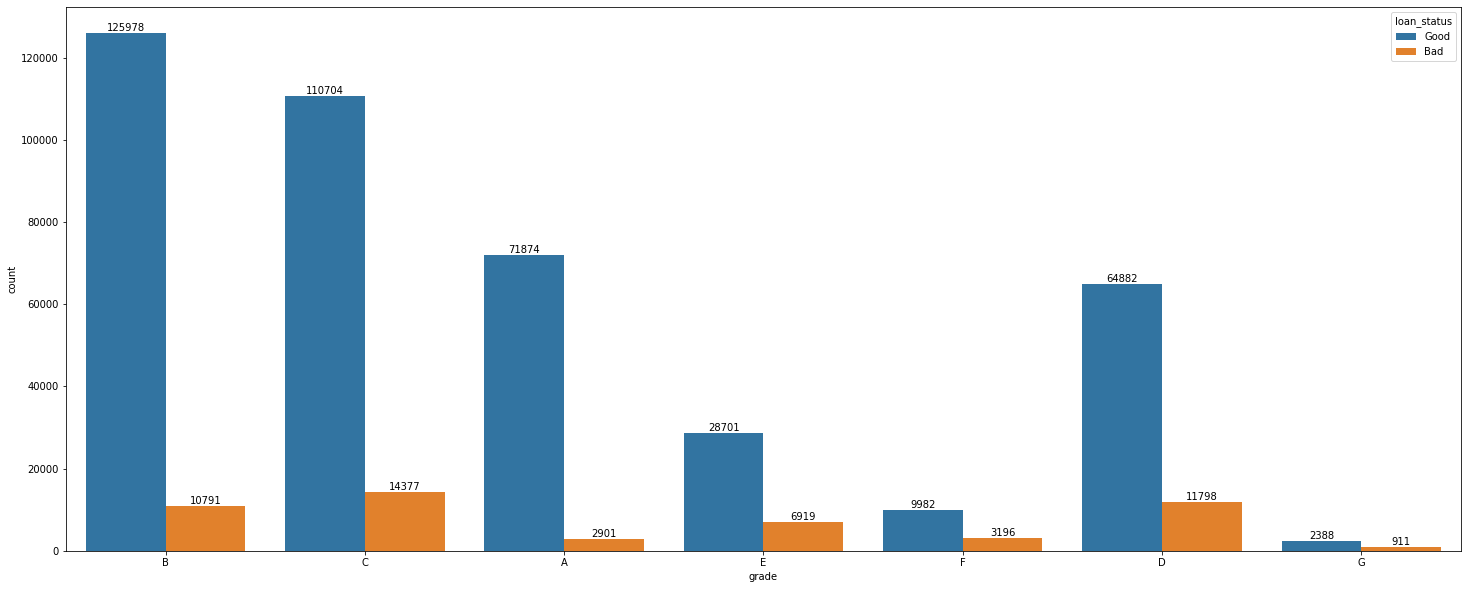

In [49]:
plt.figure(figsize=(25,10))
ax = sns.countplot(x='grade', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

top #3 dari grade ditempati oleh grade B, C, dan A. mari kita liat bad loan ratio dari ketiganya

In [73]:
print("bad loan ratio for B",df[df['grade'] == 'B'].groupby('loan_status').size()[0]
        / df[df['grade'] == 'B'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for C",df[df['grade'] == 'C'].groupby('loan_status').size()[0]
        / df[df['grade'] == 'C'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for A",df[df['grade'] == 'A'].groupby('loan_status').size()[0]
              / df[df['grade'] == 'A'].groupby('loan_status').size().sum())

bad loan ratio for B 0.07889945821055941 
bad loan ratio for C 0.11494151789640313 
bad loan ratio for A 0.038796389167502505


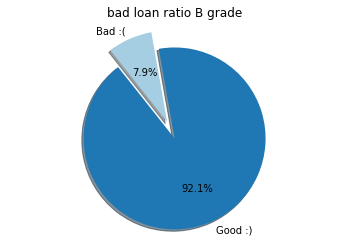

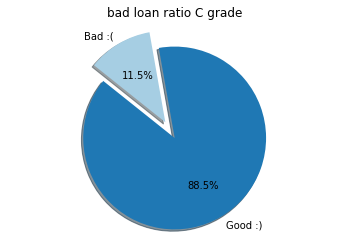

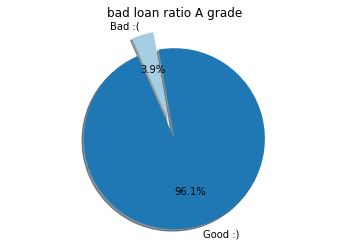

In [76]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# pie chart untuk grade B
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio B grade')
ax1.pie(df[df['grade'] == 'B'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# pie chart untuk C Grade
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio C grade')
ax1.pie(df[df['grade'] == 'C'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# pie chart untuk A grade
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio A grade')
ax1.pie(df[df['grade'] == 'A'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

Ternyata walaupun #1 ditempati oleh grade B, ternyata bad loan rationya menempati posisi kedua yaitu diangka <b>7,9%</b>. sementara itu grade A yang merupakan #3 menempati posisi pertama untuk bad loan ratio terkecil yaitu ada diangka <b>3,9%</b> dan grade C yang merupakan #2 menempati posisi ketiga untuk bad loan ratio yaitu sebesar <b>11.5%</b>

#### Melihat persebaran kolom <b>Sub Grade<b>

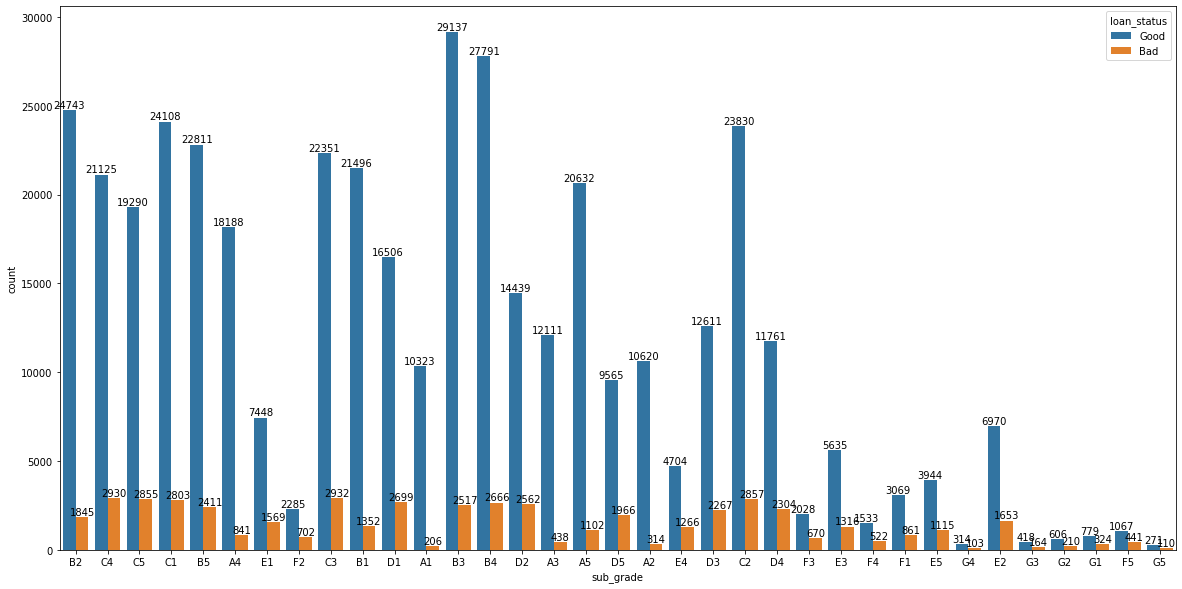

In [77]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='sub_grade', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

ternyata setelah melihat bentuk bersebaranya, menurut saya tidak banyak informasi yang bisa kita dapatkan dari kolom ini. hal itu karena kolom ini memiliki persebaran yang luas serta tidak terlihat adanya data yang berkumpul di salah satu nilai. namun, top #3 dari sub grade ditempati oleh sub grade B3 yang menempati #1, B4 yang menempati #2, dan B2 yang menempati #3

#### Melihat persebaran kolom <b>emp title<b>

karena kolom ini memiliki banyak sekali variabel unique maka dari itu saya ingin memperkecil persebarannya dengan mengambil value-value mana saja yang memiliki jumlah yang lebih dari 1000

In [51]:
# membuat sebuah variabel baru untuk menyimpan data emp title yang memiliki jumlah lebih dari 1000
job_count = df.groupby("emp_title").filter(lambda x: len(x) > 1000)

In [52]:
# menampilkan value yang memiliki jumlah lebih dari 1000
job_count.emp_title.value_counts()

Other               27508
Teacher              5392
Manager              4429
Registered Nurse     2314
RN                   2202
Supervisor           1966
Sales                1623
Project Manager      1621
Owner                1521
Office Manager       1393
manager              1311
Driver               1294
General Manager      1260
Director             1186
teacher              1182
Engineer             1048
Name: emp_title, dtype: int64

In [78]:
# melakukan filtering
import re

def job(x):
  if (re.findall("Teacher", x)):
    return 'Teacher'
  elif (re.findall("Manager", x)):
    return 'Manager'
  elif (re.findall("Registered Nurse", x)):
    return 'Registered Nurse'
  elif (re.findall("RN", x)):
    return 'Registered Nurse'
  elif (re.findall("Sales", x)):
    return 'Sales'
  elif (re.findall("Supervisor", x)):
    return 'Supervisor'
  elif (re.findall("Project Manager", x)):
    return 'Project Manager'
  elif (re.findall("Owner", x)):
    return 'Owner'
  elif (re.findall("Office Manager", x)):
    return 'Manager'
  elif (re.findall("Manager", x)):
    return 'Manager'
  elif (re.findall("Driver", x)):
    return 'Driver'
  elif (re.findall("Engineer", x)):
    return 'Engineer'
  elif (re.findall("General Manager", x)):
    return 'General Manager'
  elif (re.findall("Director", x)):
    return 'Director'
  elif (re.findall("teacher", x)):
    return 'Teacher'
  else:
    return "Other"

df["emp_title"] = df['emp_title'].apply(job)
df["emp_title"].value_counts()

Other               382885
Manager              33706
Director              9747
Teacher               8252
Engineer              7707
Sales                 6376
Supervisor            5927
Registered Nurse      5865
Driver                2775
Owner                 2162
Name: emp_title, dtype: int64

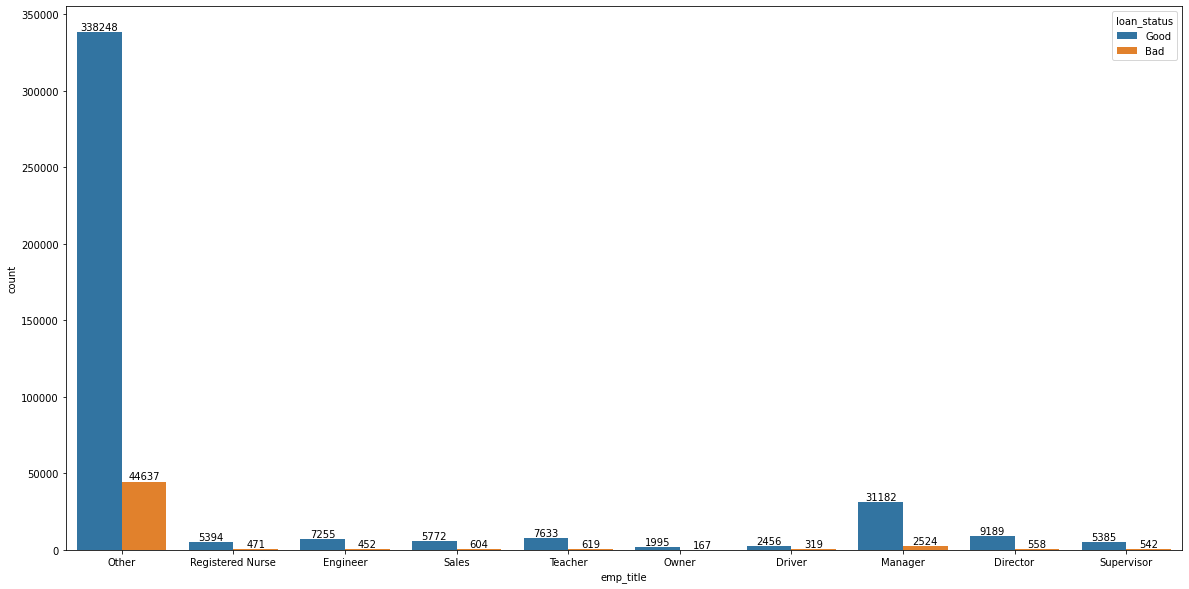

In [54]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='emp_title', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

menurut saya kolom emp title merupakan kolom yang cukup <b>complicated</b> kenapa ? karena pada awalnya kolom ini memiliki banyak sekali missing value yaitu ada diangka 27588. saya pun berusaha untuk mengimpute kolom tersebut dengan other dan mengecilkan persebarannya dengan memasukkannya ke other. namun, hal ini menyebabkan adanya penumpukan data pada kolom other. kemudian saya mulai berfikir untuk menghapus kolom ini tetapi menurut saya kolom ini adalah kolom yang cukup penting. top 3 nya ditempati oleh other sebagai #1 kemudian manager sebagai #2 yang memiliki jumlah sangat jauh bila dibandingkan dengan #1 kemudian director menempati #3

mungkin karena saya nilai kolom ini cukup penting, maka dari itu kita akan mencoba untuk melihat bagaimana bad loan ratio nya 

In [79]:
print("bad loan ratio for Other",df[df['emp_title'] == 'Other'].groupby('loan_status').size()[0]
        / df[df['emp_title'] == 'Other'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for Manager",df[df['emp_title'] == 'Manager'].groupby('loan_status').size()[0]
        / df[df['emp_title'] == 'Manager'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for Director",df[df['emp_title'] == 'Director'].groupby('loan_status').size()[0]
              / df[df['emp_title'] == 'Director'].groupby('loan_status').size().sum())

bad loan ratio for Other 0.11658069655379552 
bad loan ratio for Manager 0.07488281018216342 
bad loan ratio for Director 0.057248384118190214


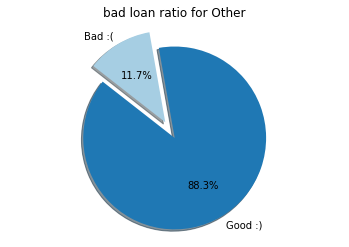

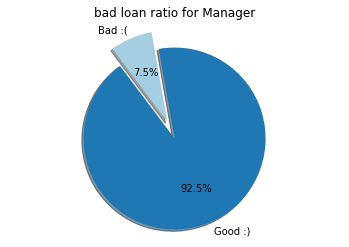

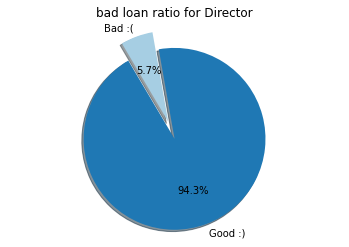

In [80]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Other')
ax1.pie(df[df['emp_title'] == 'Other'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Manager')
ax1.pie(df[df['emp_title'] == 'Manager'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Director')
ax1.pie(df[df['emp_title'] == 'Director'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

urutan bad loan ratio mulai dari yang terkecil adalah director dengan bad loan ratio diangka <b>5.7%</b>, kemudian manager diangka <b>7.5&</b>, dan Other diangka <b>11.7%</b>

#### Melihat persebaran kolom <b>emp length<b>

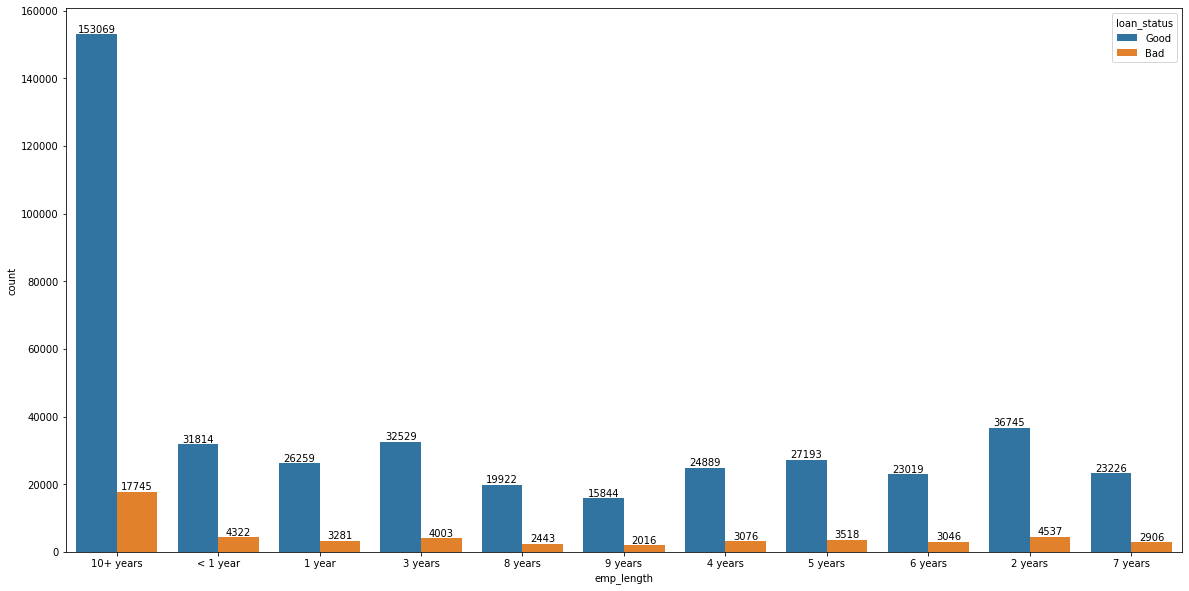

In [55]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='emp_length', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

top 3 kolom ini ditempati oleh 10+years sebagai #1, 2 years sebagai #2 dan 3 years sebagai #3

mari kita lihat bad loan rationya

In [86]:
print("bad loan ratio for 10+ years",df[df['emp_length'] == '10+ years'].groupby('loan_status').size()[0]
        / df[df['emp_length'] == '10+ years'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for 2 years",df[df['emp_length'] == '2 years'].groupby('loan_status').size()[0]
        / df[df['emp_length'] == '2 years'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for 3 years",df[df['emp_length'] == '3 years'].groupby('loan_status').size()[0]
              / df[df['emp_length'] == '3 years'].groupby('loan_status').size().sum())

bad loan ratio for 10+ years 0.10388492746496189 
bad loan ratio for 2 years 0.10990262099704472 
bad loan ratio for 3 years 0.10957516697689697


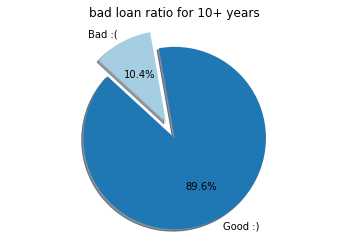

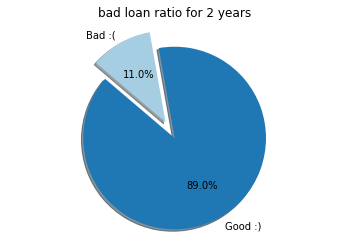

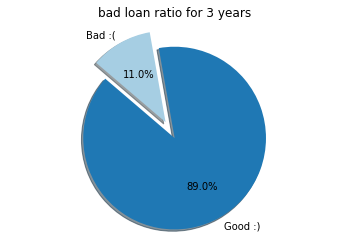

In [83]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2) 

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for 10+ years')
ax1.pie(df[df['emp_length'] == '10+ years'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for 2 years')
ax1.pie(df[df['emp_length'] == '2 years'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for 3 years')
ax1.pie(df[df['emp_length'] == '3 years'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

bad loan terkecil pertama ditempati oleh 10+years yaitu sebesar <b>10.4</b>, kedua ditempati oleh 3 years <b>10.95</b>, dan ketiga ditempati oleh 2 years yaitu <b>10.99</b>. karena di char hanya sampai satu angka dibelakang koma jadi kelihatannya 3 years dan 2 years terlihat sama 

#### Melihat persebaran kolom <b>home ownership<b>

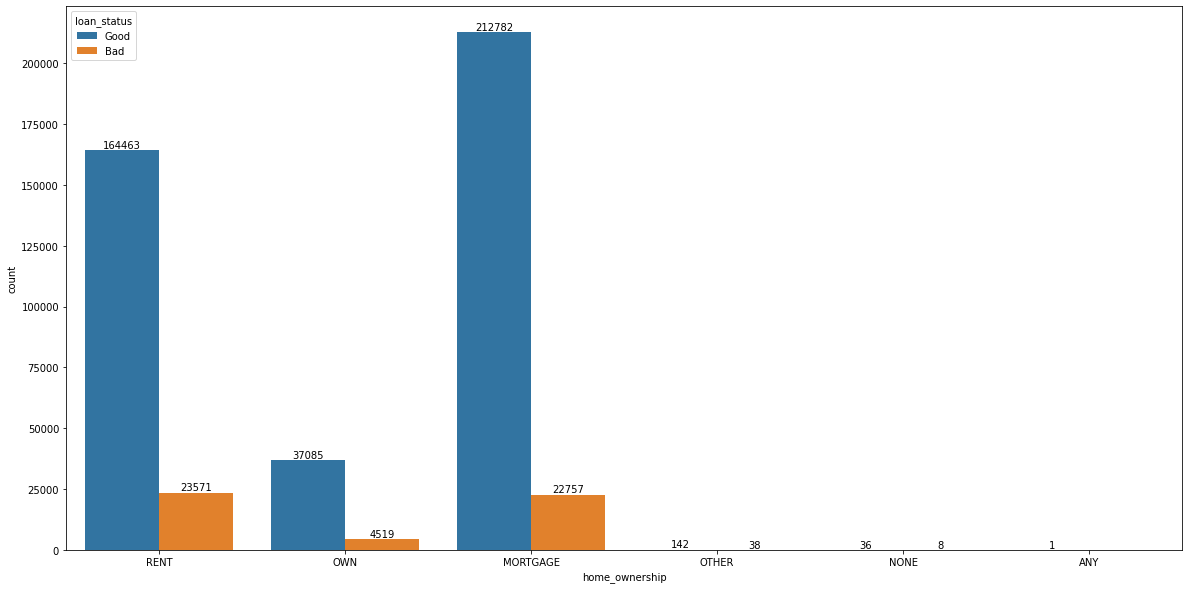

In [56]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='home_ownership', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

untuk kolom ini, sebenarnya terdiri dari 6 value namun didominasi oleh 3 value yaitu rent sebagai #2, own sebagai #3, dan mortgage sebagai #1

mari kita lihat bad loan ratio nya

In [85]:
print("bad loan ratio for RENT",df[df['home_ownership'] == 'RENT'].groupby('loan_status').size()[0]
        / df[df['home_ownership'] == 'RENT'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for OWN",df[df['home_ownership'] == 'OWN'].groupby('loan_status').size()[0]
        / df[df['home_ownership'] == 'OWN'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for MORTGAGE",df[df['home_ownership'] == 'MORTGAGE'].groupby('loan_status').size()[0]
              / df[df['home_ownership'] == 'MORTGAGE'].groupby('loan_status').size().sum())

bad loan ratio for RENT 0.12535498899135264 
bad loan ratio for OWN 0.1086193635227382 
bad loan ratio for MORTGAGE 0.09661669617345747


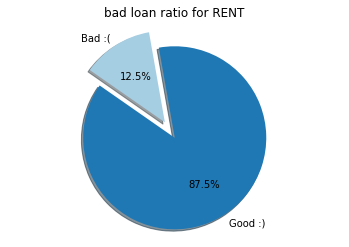

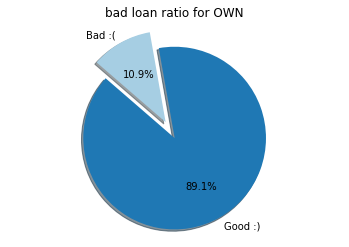

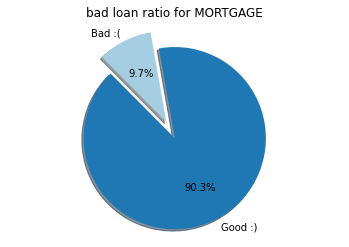

In [87]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for RENT')
ax1.pie(df[df['home_ownership'] == 'RENT'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for OWN')
ax1.pie(df[df['home_ownership'] == 'OWN'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for MORTGAGE')
ax1.pie(df[df['home_ownership'] == 'MORTGAGE'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

berbeda dari kolom2 sebelumnya yang #1 yang memiliki bad loan ratio yang cukup besar, pada kolom ini #1 yaitu mortage memiliki bad loan ratio terkecil yaitu sebesar <b>9.7%</b>, kemudian disusul oleh own yang menempati posisi 2 dengan bad loan ratio sebesar <b> 10.9% </b>, dan Rent penempati posisi 3 dengan bad loan ratio sebesar <b> 12.5% </b>

#### Melihat persebaran kolom <b>verification status<b>

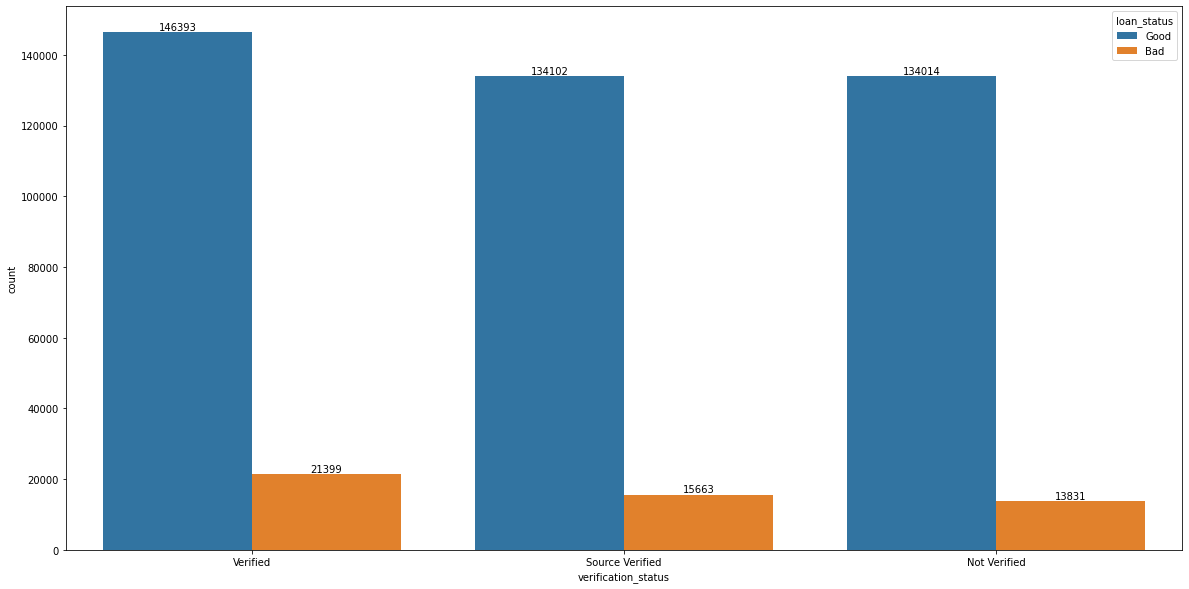

In [57]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='verification_status', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

kolom ini terdiri dari 3 variabel nilai unique yaitu verified yang menempati posisi terbanyak pertama, source verified menempati posisi tebanyak kedua, dan not verified dan not verified menempati posisi terbanyak ketiga. 

mari kita lihat bad loan ratio nya 

In [88]:
print("bad loan ratio for Verified",df[df['verification_status'] == 'Verified'].groupby('loan_status').size()[0]
        / df[df['verification_status'] == 'Verified'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for Source Verified",df[df['verification_status'] == 'Source Verified'].groupby('loan_status').size()[0]
        / df[df['verification_status'] == 'Source Verified'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for Not Verified",df[df['verification_status'] == 'Not Verified'].groupby('loan_status').size()[0]
              / df[df['verification_status'] == 'Not Verified'].groupby('loan_status').size().sum())

bad loan ratio for Verified 0.12753289787355773 
bad loan ratio for Source Verified 0.1045838480285781 
bad loan ratio for Not Verified 0.093550678075011


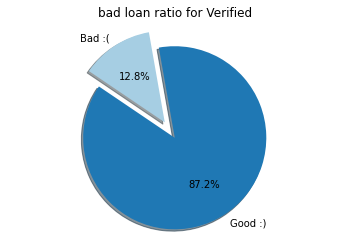

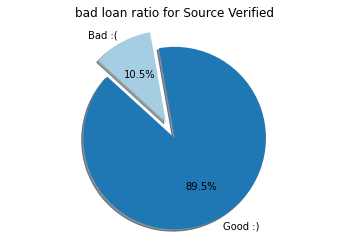

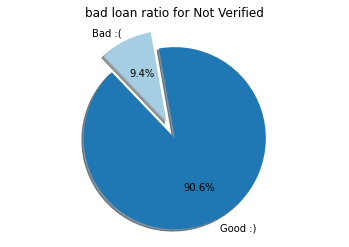

In [89]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Verified')
ax1.pie(df[df['verification_status'] == 'Verified'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Source Verified')
ax1.pie(df[df['verification_status'] == 'Source Verified'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Not Verified')
ax1.pie(df[df['verification_status'] == 'Not Verified'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

bad loan ratio terkecil ditempati oleh not verified dengan tingkat bad loan ratio sebesar <b>9.4%</b>, disusul oleh source verified dengan bad loan ratio sebesar <b>10.5%</b>, dan yang terakhir ditempati oleh verified dengan tingkat bad loan ratio sebesar <b> 12.8%</b>

#### Melihat persebaran kolom <b>pymnt_plan<b>

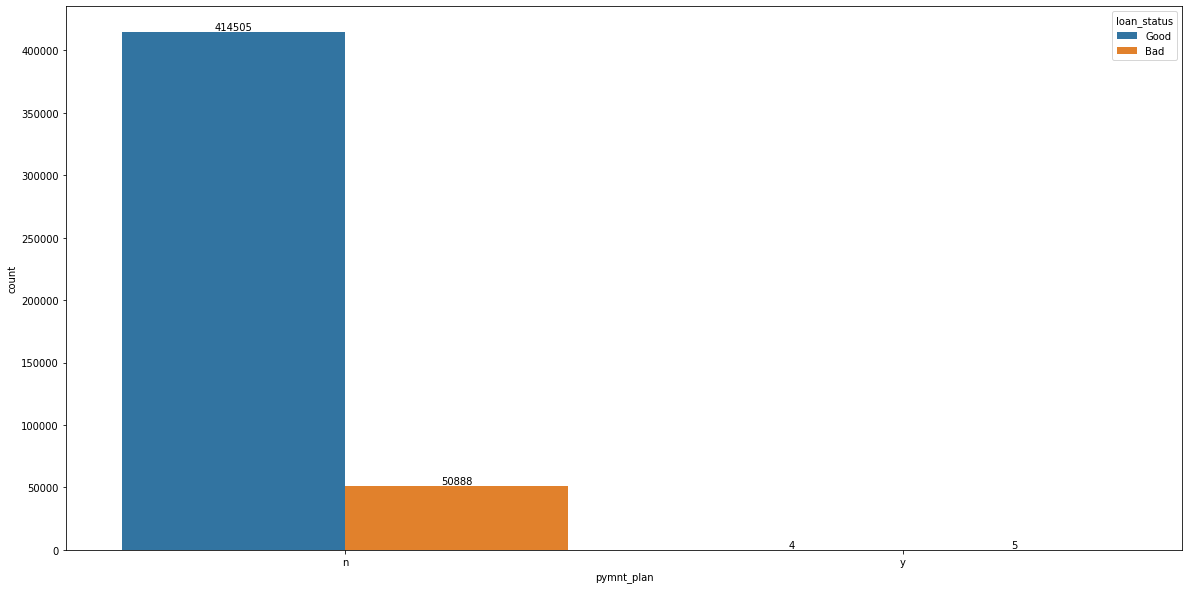

In [58]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='pymnt_plan', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

ternyata kolom ini sama  dengan kolom aplication type, kolom pymnt plan juga hanya memiliki satu nilai maka dari itu, kolom ini juga harus dihapus

In [59]:
df.drop(columns=['pymnt_plan'], inplace=True)

#### Melihat persebaran kolom <b>Purpose<b>

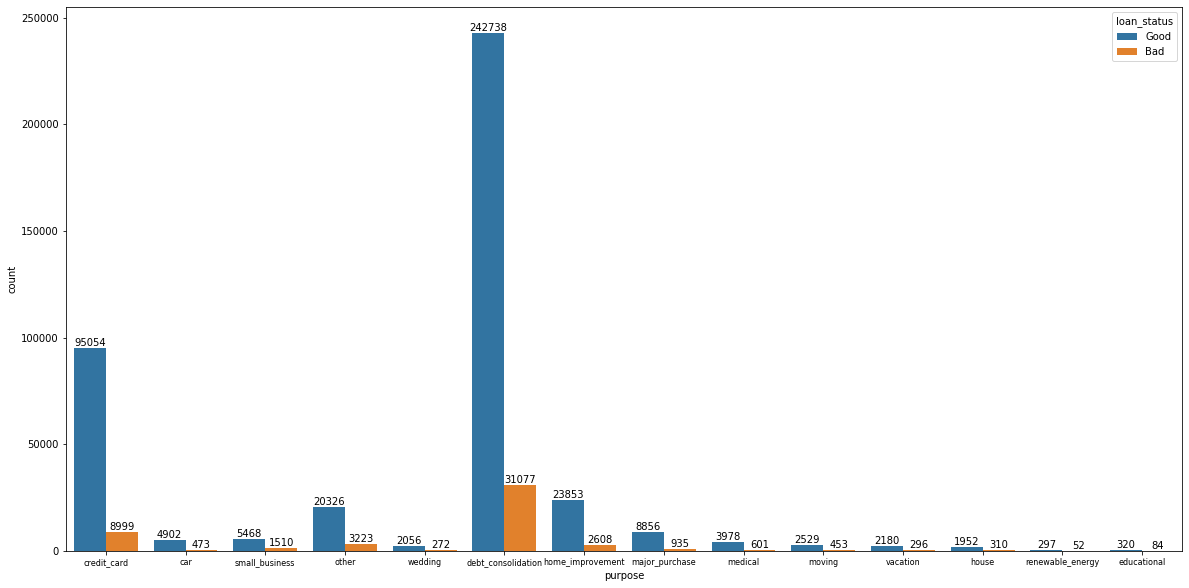

In [60]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='purpose', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)
plt.xticks(size=8)

plt.show()

ternyata berdasarkan data ini, kebanyakan org yang mengajukan kredit memiliki tujuan untuk debt_consolidation atau upaya penggabungan beberapa pinjaman tanpa jaminan menjadi satu pinjaman dengan nilai atau plafon yang lebih besar.

debt_consolidation menempati posisi pertama, disusul dengan credit_card diposisi kedua, dan home_improvment di posisi ketiga

sekarang mari kita lihat bagaimana bad load rationya

In [90]:
print("bad loan ratio for debt_consolidation",df[df['purpose'] == 'debt_consolidation'].groupby('loan_status').size()[0]
        / df[df['purpose'] == 'debt_consolidation'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for credit_card",df[df['purpose'] == 'credit_card'].groupby('loan_status').size()[0]
        / df[df['purpose'] == 'credit_card'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for home_improvement",df[df['purpose'] == 'home_improvement'].groupby('loan_status').size()[0]
              / df[df['purpose'] == 'home_improvement'].groupby('loan_status').size().sum())

bad loan ratio for debt_consolidation 0.1134963387688768 
bad loan ratio for credit_card 0.08648477218340653 
bad loan ratio for home_improvement 0.09856014511923208


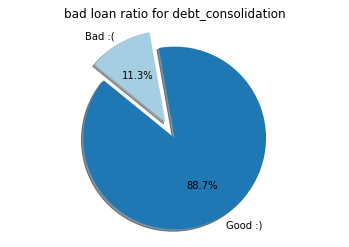

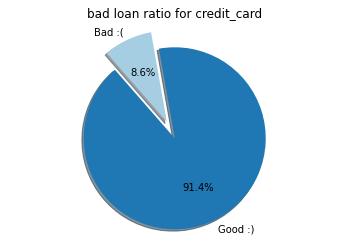

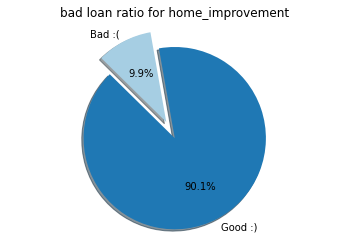

In [92]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for debt_consolidation')
ax1.pie(df[df['purpose'] == 'debt_consolidation'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for credit_card')
ax1.pie(df[df['purpose'] == 'credit_card'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for home_improvement')
ax1.pie(df[df['purpose'] == 'home_improvement'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

bad loan terkecil ditempati oleh credit_card dengan tingkat bad loan ratio sebesar <b>8.6%</b> disusul oleh home_improvment  dengan tingkat loan ratio sebesar <b>9.9%</b> dan yang terakhir debt_consolidation dengan tingkat bad loan ratio sebesar <b>11.3%</b>

#### Melihat persebaran kolom <b>Title<b>

sama seperti kolom emp_title, kolom ini juga memiliki banyak sekali nilai unique maka dari itu saya berniat untuk mempersempit nilai tersebut dengan memfilter dan menggabungkannya pada other

In [61]:
df['title'].value_counts()

Debt consolidation                   163888
Credit card refinancing               62233
Debt Consolidation                    15741
Home improvement                      14817
Other                                 12678
                                      ...  
Becoming Fiscally Fit                     1
a clean slate                             1
Crush MY Credit Card                      1
Controlling My Financial Future           1
Paying off the car and some bills         1
Name: title, Length: 62879, dtype: int64

saya memfilter nilai unique berdasarkan value countnya. nilai yang memiliki value count lebih dari 1000 akan tetap tetapi nilai yang memiliki value count kurang dari 1000 akan menjadi other

In [62]:
#membuat variabel untuk menampung nilai hasil filtering
title_count = df.groupby("title").filter(lambda x: len(x) > 1000)

In [63]:
# menampilkan hasil filtering
title_count['title'].value_counts()

Debt consolidation           163888
Credit card refinancing       62233
Debt Consolidation            15741
Home improvement              14817
Other                         12678
Consolidation                  5373
debt consolidation             4829
Major purchase                 4607
Debt Consolidation Loan        3796
Business                       3361
Medical expenses               2734
Credit Card Consolidation      2356
consolidation                  2172
Personal Loan                  2124
Car financing                  2086
Consolidation Loan             1775
Home Improvement               1766
Vacation                       1555
Moving and relocation          1495
Credit Card Refinance          1466
Credit Card Payoff             1385
Consolidate                    1263
Personal                       1181
Loan                           1029
Name: title, dtype: int64

In [64]:
# memfilter

import re

def title(x):
  if (re.findall("Debt consolidation", x)):
    return 'Debt consolidation'
  elif (re.findall("Credit card refinancing", x)):
    return 'Credit card refinancing'
  elif (re.findall("Debt Consolidation", x)):
    return 'Debt Consolidation'
  elif (re.findall("Home improvement", x)):
    return 'Home improvement'
  elif (re.findall("Other", x)):
    return 'Other'
  elif (re.findall("Consolidation", x)):
    return 'Consolidation'
  elif (re.findall("debt consolidation", x)):
    return 'debt consolidation'
  elif (re.findall("Major purchase", x)):
    return 'Major purchase'
  elif (re.findall("Debt Consolidation Loan", x)):
    return 'Debt Consolidation Loan'
  elif (re.findall("Business", x)):
    return 'Business'
  elif (re.findall("Medical expenses", x)):
    return 'Medical expenses'
  elif (re.findall("Credit Card Consolidation", x)):
    return 'Credit Card Consolidation'
  elif (re.findall("consolidation", x)):
    return 'Consolidation'
  elif (re.findall("Personal Loan", x)):
    return 'Personal Loan'
  elif (re.findall("Home Improvement", x)):
    return 'Home Improvement'
  elif (re.findall("Vacation", x)):
    return 'Vacation'
  elif (re.findall("Moving and relocation", x)):
    return 'Moving and relocation'
  elif (re.findall("Credit Card Refinance", x)):
    return 'Credit Card Refinance'
  elif (re.findall("Credit Card Payoff", x)):
    return 'Credit Card Payoff'
  elif (re.findall("Consolidate", x)):
    return 'Consolidate'
  elif (re.findall("Personal", x)):
    return 'Personal'
  elif (re.findall("Loan", x)):
    return 'Loan'
  else:
    return "Other"

df["title"] = df['title'].apply(title)
df["title"].value_counts()

Debt consolidation         164995
Other                      127222
Credit card refinancing     62255
Debt Consolidation          23305
Consolidation               21937
Home improvement            15119
Loan                        13482
debt consolidation           6313
Business                     5169
Major purchase               4621
Consolidate                  3611
Home Improvement             3153
Medical expenses             2742
Personal Loan                2583
Personal                     2078
Vacation                     1891
Credit Card Refinance        1760
Credit Card Payoff           1670
Moving and relocation        1496
Name: title, dtype: int64

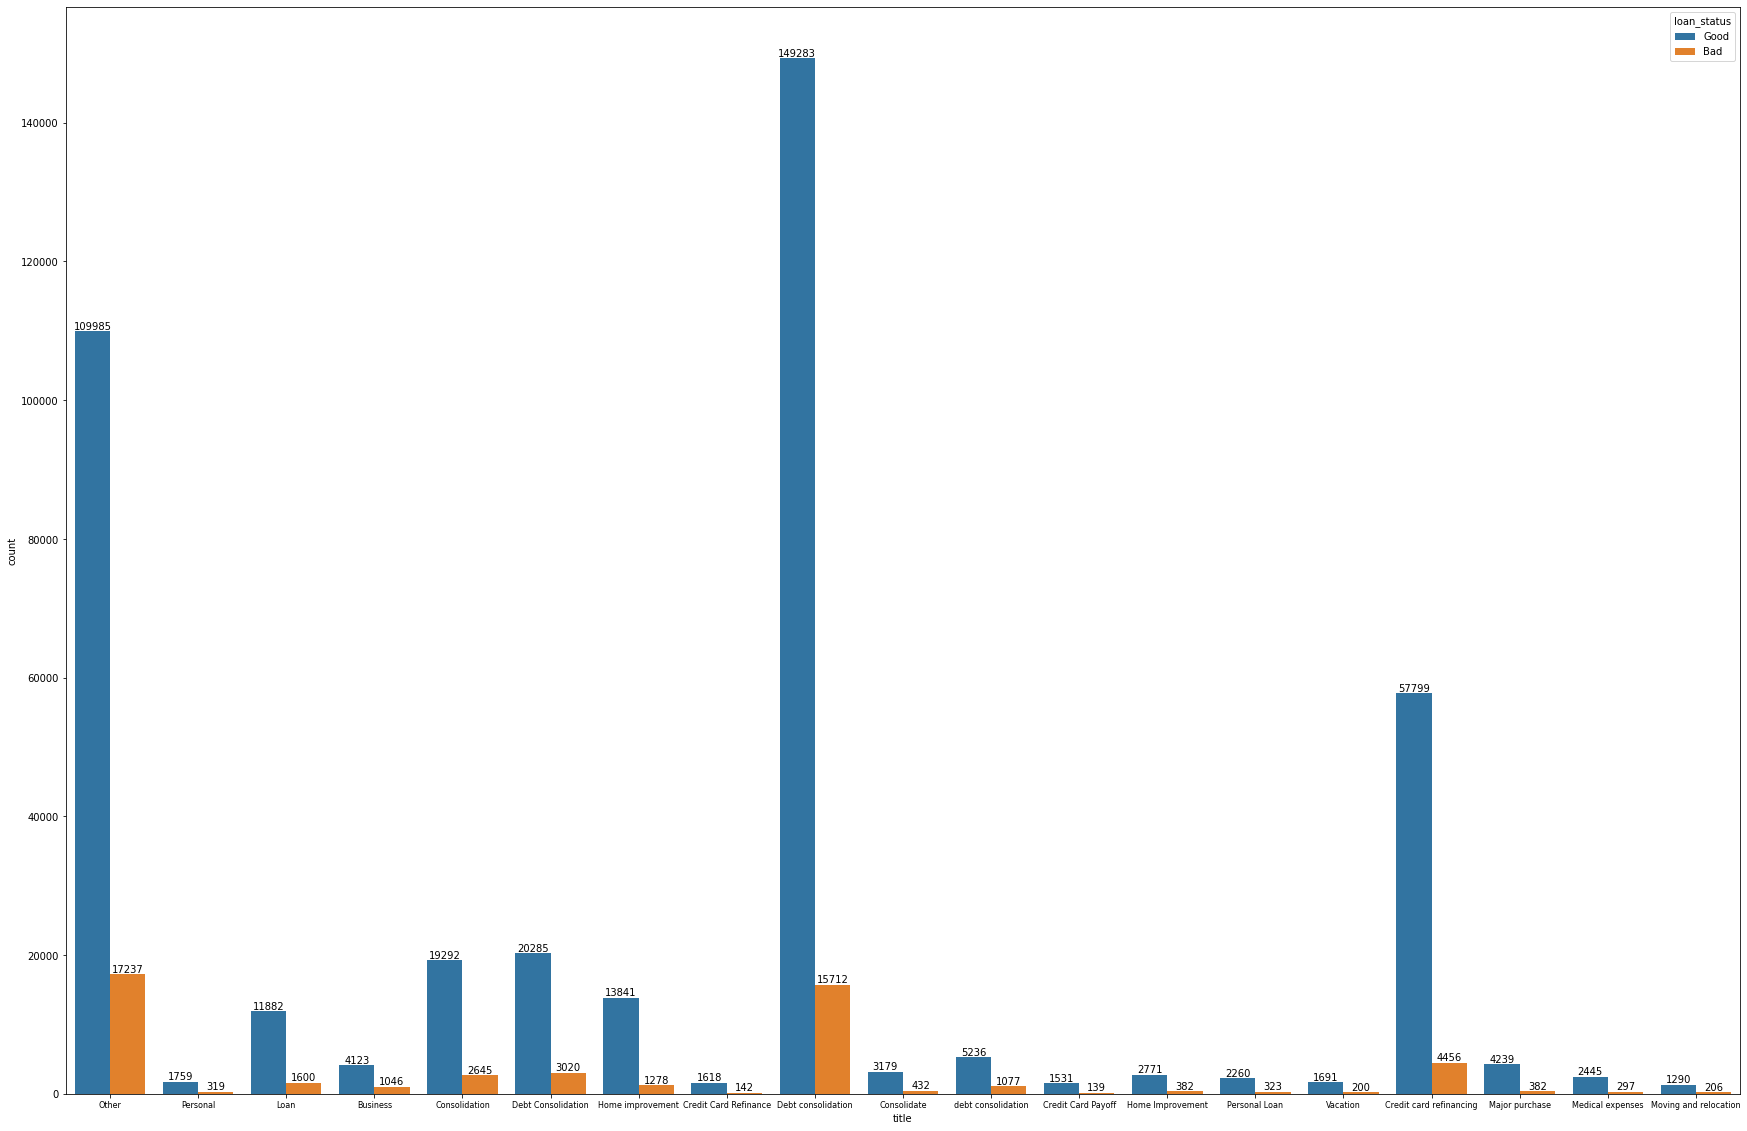

In [65]:
plt.figure(figsize=(30,20))
ax = sns.countplot(x='title', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.xticks(size=8)

plt.show()

dari grafik tersebut dapat kita lihat bahwa, posisi pertama ditempati oleh debt consolidation, disusul oleh other, dan credit card refinancing

sekarang mari kita lihat bad loan ratio untuk top 3 dari kolom ini

In [93]:
print("bad loan ratio for Debt consolidation",df[df['title'] == 'Debt consolidation'].groupby('loan_status').size()[0]
        / df[df['title'] == 'Debt consolidation'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for Credit card refinancing",df[df['title'] == 'Credit card refinancing'].groupby('loan_status').size()[0]
        / df[df['title'] == 'Credit card refinancing'].groupby('loan_status').size().sum(),
      "\nbad loan ratio for Other",df[df['title'] == 'Other'].groupby('loan_status').size()[0]
              / df[df['title'] == 'Other'].groupby('loan_status').size().sum())

bad loan ratio for Debt consolidation 0.09522712809479075 
bad loan ratio for Credit card refinancing 0.0715765801943619 
bad loan ratio for Other 0.13548757290405747


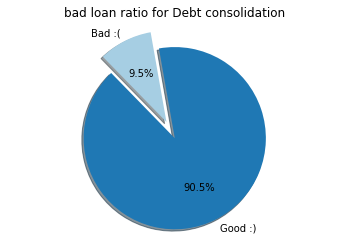

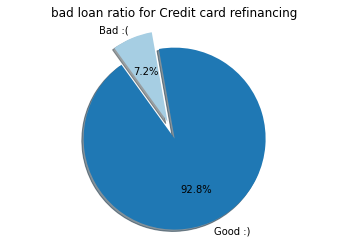

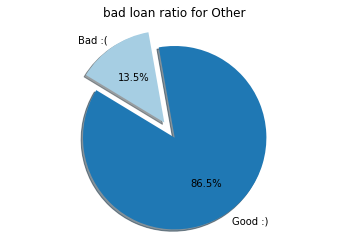

In [94]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Debt consolidation')
ax1.pie(df[df['title'] == 'Debt consolidation'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Credit card refinancing')
ax1.pie(df[df['title'] == 'Credit card refinancing'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Director
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for Other')
ax1.pie(df[df['title'] == 'Other'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

plt.show()

ternyata bad loan ratio terkecil diduduki oleh credit card refinancing dengan tingkat bad loan ratio sebesar <b> 7.2% </b>, disusul oleh debt consolidation dengan tingkat bad loan ratio sebesar <b> 9.5% </b> dan yang terakhir adalah other dengan tingkat  bad loan ratio sebesar <b> 13.5%</b>

### Melihat persebaran kolom <b>Initial List Status<b>

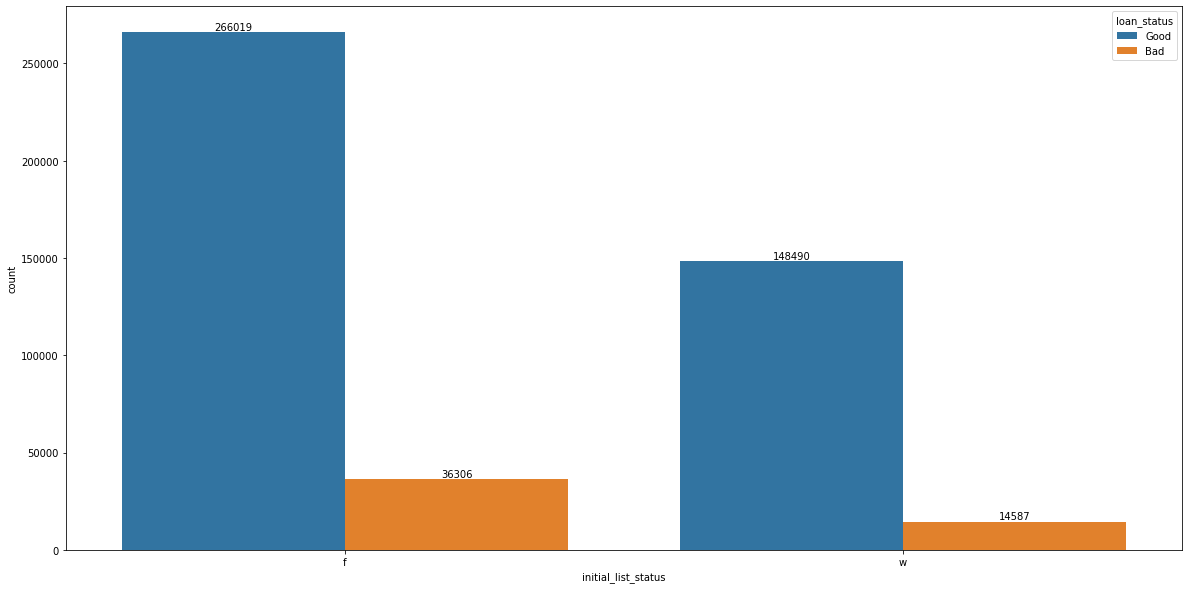

In [66]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='initial_list_status', data=df, hue='loan_status')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

kolom ini berisi dua nilai unique yaitu f dan w yang mana secara value f memiliki value count yang lebih banyak dibandingkan w. 

coba sekarang kita lihat bad loan ratio nya

In [95]:
print("bad loan ratio for f",df[df['initial_list_status'] == 'f'].groupby('loan_status').size()[0]
        / df[df['initial_list_status'] == 'f'].groupby('loan_status').size().sum(), 
      "\nbad loan ratio for w",df[df['initial_list_status'] == 'w'].groupby('loan_status').size()[0]
        / df[df['initial_list_status'] == 'w'].groupby('loan_status').size().sum())

bad loan ratio for f 0.12008930786405358 
bad loan ratio for w 0.08944854271295155


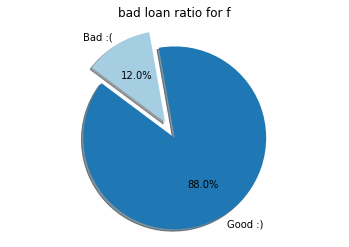

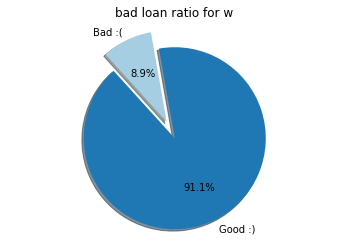

In [96]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Bad :(', 'Good :)']
explode = (0, 0.2)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# bad loan ratio for Other
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for f')
ax1.pie(df[df['initial_list_status'] == 'f'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')

# bad loan ratio for Manager
fig1, ax1 = plt.subplots()
plt.title('bad loan ratio for w')
ax1.pie(df[df['initial_list_status'] == 'w'].groupby('loan_status').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')


plt.show()

ternyata W memiliki bad loan yang lebih kecil dibandingkan dengan f yaitu diangka <b> 8.9%</b> dan f diangka <b>12.0%</b>

<AxesSubplot:xlabel='initial_list_status', ylabel='count'>

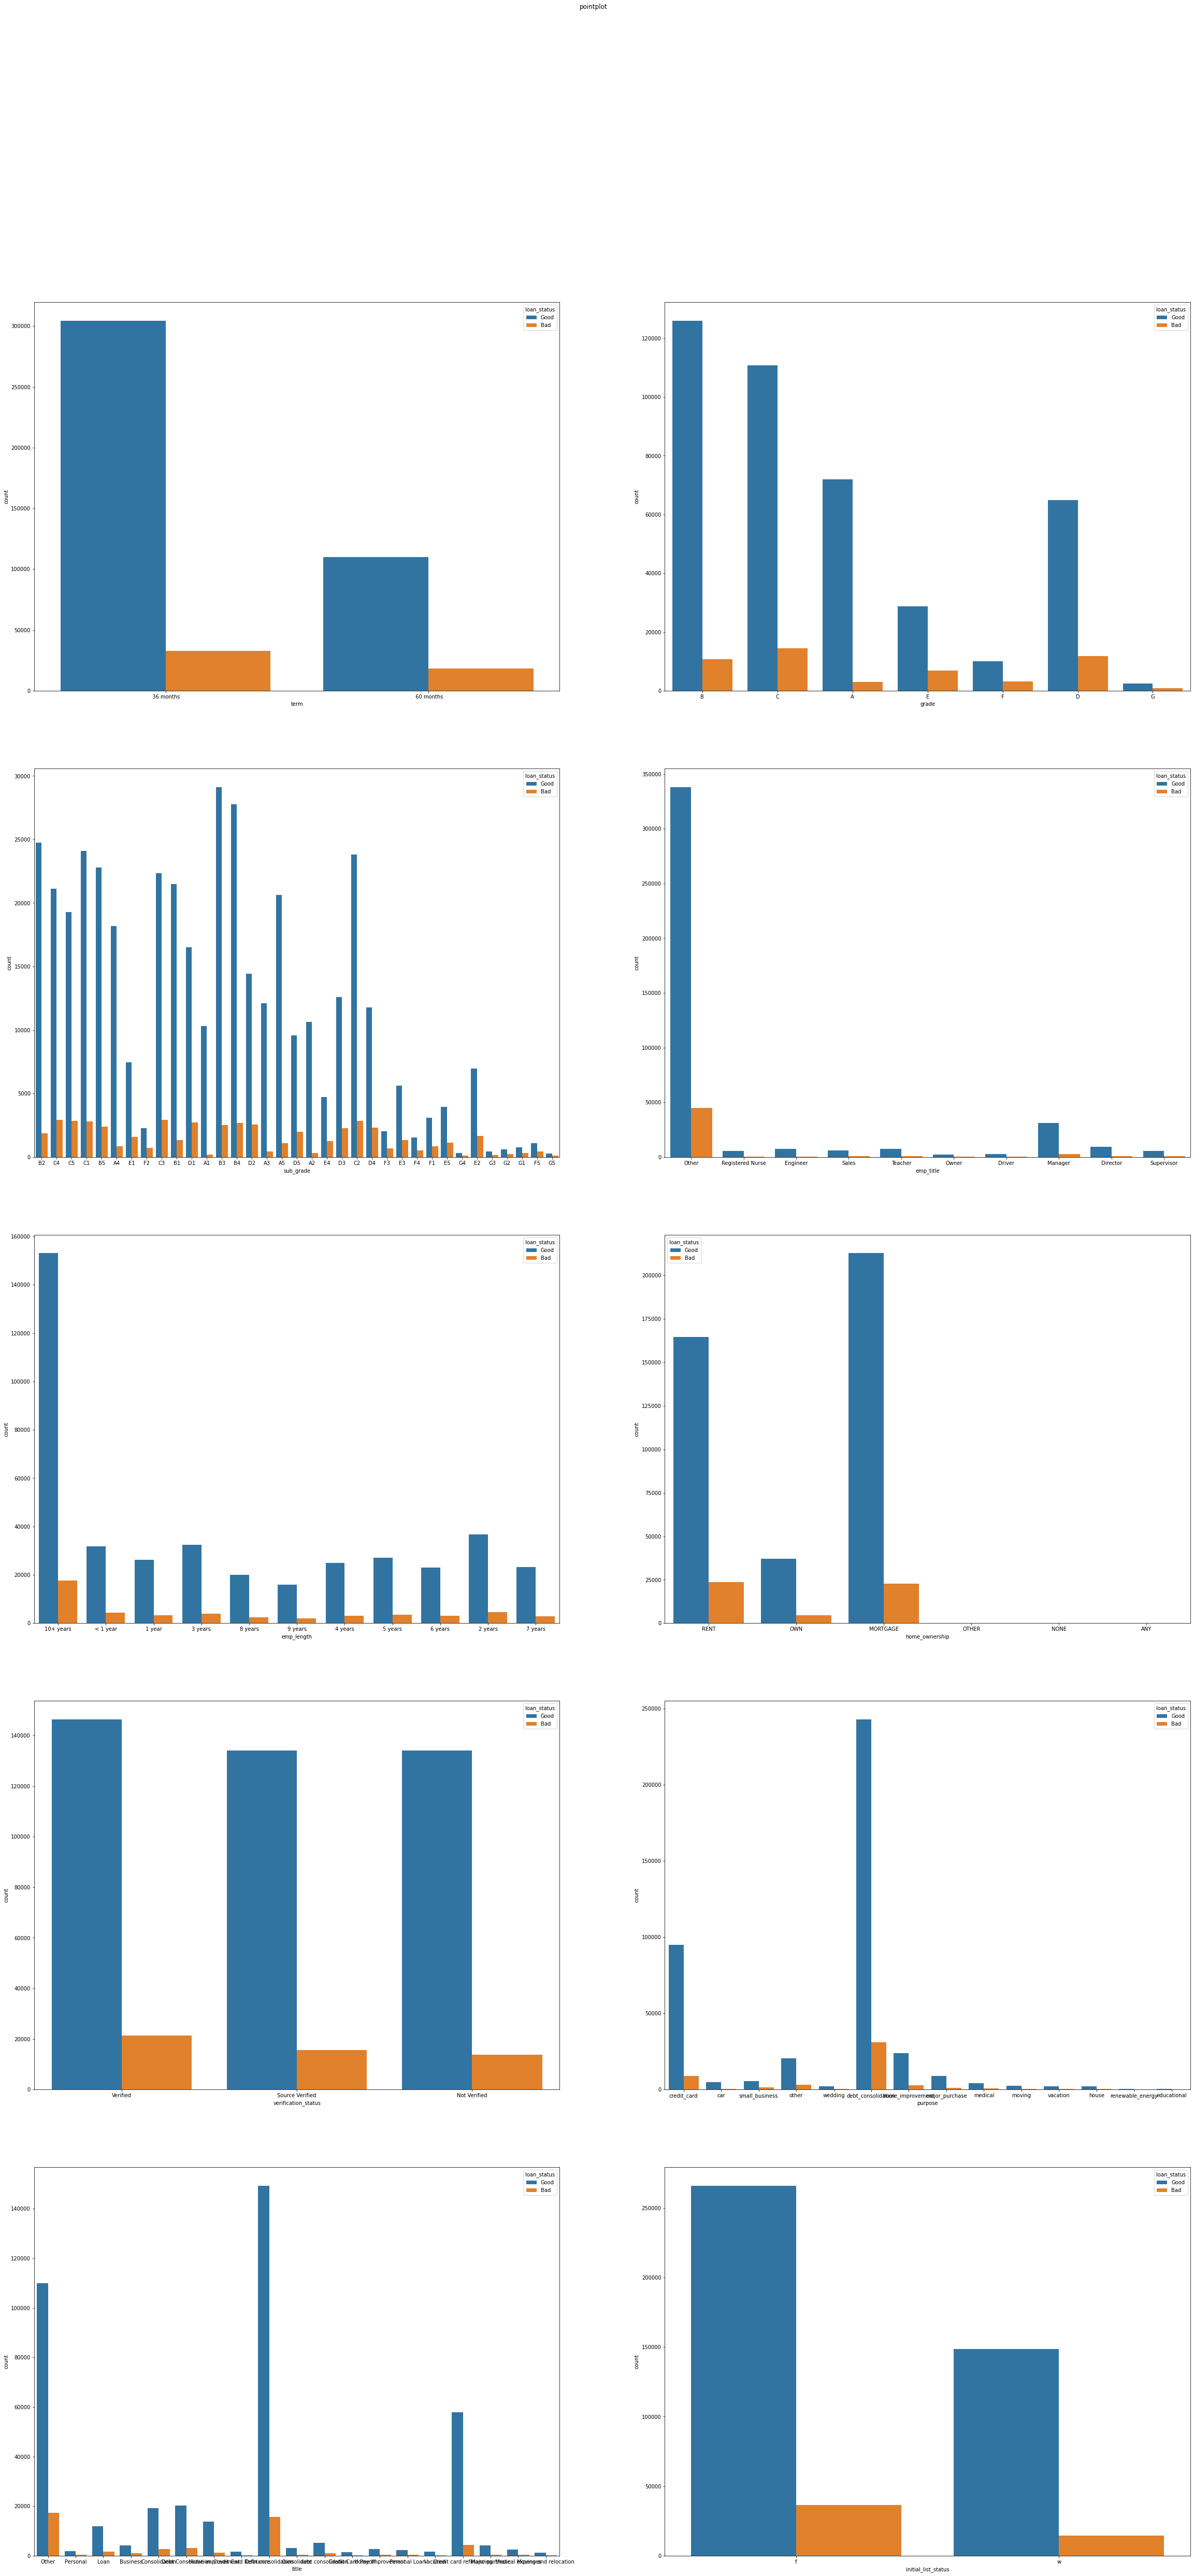

In [67]:
fig, axes = plt.subplots(5, 2, figsize=(40, 80))
fig.suptitle("pointplot")

# term
sns.countplot(x='term', data=df, hue='loan_status', ax=axes[0, 0])

# grade
sns.countplot(x='grade', data=df, hue='loan_status', ax=axes[0, 1])

# sub_grade
sns.countplot(x='sub_grade', data=df, hue='loan_status', ax=axes[1, 0])

# emp_title
sns.countplot(x='emp_title', data=df, hue='loan_status', ax=axes[1, 1])

# emp_length
sns.countplot(x='emp_length', data=df, hue='loan_status', ax=axes[2, 0])

# home_ownership
sns.countplot(x='home_ownership', data=df, hue='loan_status', ax=axes[2, 1])

# verification_status
sns.countplot(x='verification_status', data=df, hue='loan_status', ax=axes[3, 0])

#purpose
sns.countplot(x='purpose', data=df, hue='loan_status', ax=axes[3, 1])

# title
sns.countplot(x='title', data=df, hue='loan_status', ax=axes[4, 0])

# initial_list_status
sns.countplot(x='initial_list_status', data=df, hue='loan_status', ax=axes[4, 1])

In [68]:
cat.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,initial_list_status
0,36 months,B,B2,Other,10+ years,RENT,Verified,Good,n,credit_card,Computer,f
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Bad,n,car,bike,f
2,36 months,C,C5,Other,10+ years,RENT,Not Verified,Good,n,small_business,real estate business,f
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Good,n,other,personel,f
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Good,n,other,Personal,f


In [69]:
pd.set_option('display.max_columns', None)

In [70]:
num.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,1,0.0,191.913517,138801.713385,30379.087771
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,1,0.0,191.913517,138801.713385,30379.087771
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,1,0.0,191.913517,138801.713385,30379.087771
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,1,0.0,191.913517,138801.713385,30379.087771
4,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,1,0.0,191.913517,138801.713385,30379.087771
